<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/12_5_Minibatch_Stochastic_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
%matplotlib inline
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [ ]:
class Timer:
  """Record multiple running times."""
  def __init__(self):
    self.times = []
    self.start()

  def start(self):
    """Start the timer."""
    self.tik = time.time()

  def stop(self):
    """Stop the timer and record the time in a list."""
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """Return the average time."""
    return sum(self.times) / len(self.times)

  def sum(self):
    """Return the sum of time."""
    return sum(self.times)

  def cumsum(self):
    """Return the accumultated time."""
    return np.array(self.times).cumsum().tolist()
timer = Timer()

In [ ]:
# Compute A = BC on element at a time
timer.start()
for i  in range(256):
  for j in range(256):
    A[i,j] = torch.dot(B[i,:], C[:, j])
timer.stop()

1.2106001377105713

In [ ]:
timer.start()
for j in range(256):
  A[:, j] = torch.mv(B,C[:,j])
timer.stop()

0.014724254608154297

In [ ]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()
gigaflops = [0.03 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.025, column 2.037, full 2.148


In [ ]:
timer.start()
for j in range(0, 256, 64):
  A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {0.03 / timer.times[3]:.3f}')

performance in Gigaflops: block 23.480


In [ ]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat', '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
  data = np.genfromtxt(d2l.download('airfoil'),
                       dtype=np.float32, delimiter='\t')
  data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
  data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                             batch_size, is_train=True)
  return data_iter, data.shape[1]-1

In [ ]:
def sgd(params, states, hyperparams):
  for p in params:
    p.data.sub_(hyperparams['lr'] * p.grad)
    p.grad.data.zero_()

In [ ]:
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
  w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
  b = torch.zeros((1), requires_grad=True)
  net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss

  # Train
  animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])

  n, timer = 0, d2l.Timer()
  for _ in range(num_epochs):
    for X, y in data_iter:
      l = loss(net(X), y). mean()
      l.backward()
      trainer_fn([w, b], states, hyperparams)
      n += X.shape[0]
      if n % 200 == 0:
        timer.stop()
        animator.add(n/X.shape[0]/ len(data_iter), (d2l.evaluate_loss(net, data_iter, loss),))
        timer.start()

  print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
  return timer.cumsum(), animator.Y[0]

In [ ]:
batch_size = 1500
get_data_ch11(batch_size)

(<torch.utils.data.dataloader.DataLoader at 0x7968adbaf550>, 5)

loss: 0.244, 0.039 sec/epoch


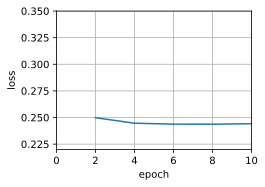

In [ ]:
def train_sgd(lr, batch_size, num_epochs=2):
  data_iter, feature_dim = get_data_ch11(batch_size)
  return train_ch11(
      sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.251, 0.557 sec/epoch


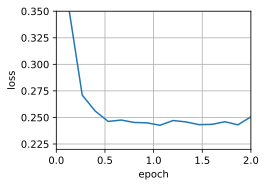

In [ ]:
sgd_res = train_sgd(0.005, 1)

loss: 0.247, 0.036 sec/epoch


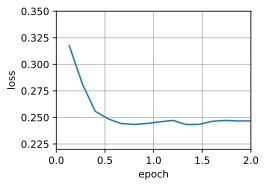

In [ ]:
mini1_res = train_sgd(.4, 100)

loss: 0.243, 0.089 sec/epoch


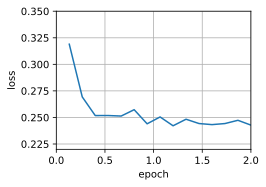

In [ ]:
mini2_res = train_sgd(.05, 10)

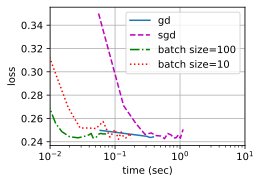

In [ ]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

In [ ]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
  net=nn.Sequential(nn.Linear(5,1))
  def init_weights(module):
    if type(module) == nn.Linear:
      torch.nn.init.normal_(module.weight, std=0.01)
  net.apply(init_weights)

  optimizer = trainer_fn(net.parameters(), **hyperparams)
  loss = nn.MSELoss(reduction='none')
  animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])

  n, timer = 0, d2l.Timer()
  for _ in range(num_epochs):
    for X, y in data_iter:
      optimizer.zero_grad()
      out = net(X)
      y = y.reshape(out.shape)
      l = loss(out, y)
      l.mean().backward()
      optimizer.step()
      n += X.shape[0]
      if n % 200 == 0:
        timer.stop()
        animator.add(n/X.shape[0]/len(data_iter),
                     (d2l.evaluate_loss(net, data_iter, loss) / 2,))
        timer.start()
  print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

loss: 0.242, 0.117 sec/epoch


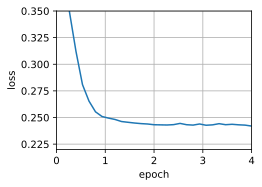

In [ ]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)